In [3]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

In [1]:
from PIL import Image

In [8]:
img = np.array(Image.open('../../data/line_detection/neuron01.png'))

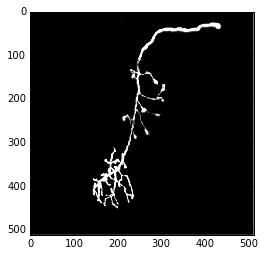

In [9]:
plt.imshow(img.T/255. )

In [11]:
plt.hist(img.flatten()[mask_vec])

NameError: name 'mask_vec' is not defined

In [2]:
import theano

In [3]:
feature_vec, gt_vec, mask_vec = TN_utils.load_neuron()

feature_vec.shape (262144, 60, 2)
GT_vec.shape (262144, 2)
mask_vec.shape (262144,)


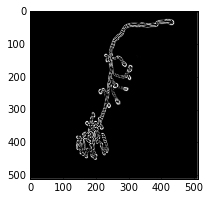

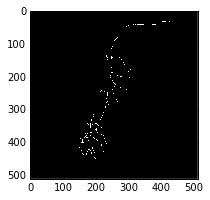

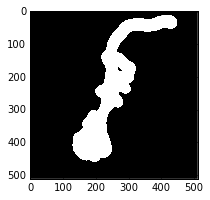

In [4]:
# V test load_toytreefeature_mat
im_shape = (512, 512)
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(feature_vec, axis=2)[:, 12].reshape(im_shape))

plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(gt_vec, axis=1).reshape(im_shape)) 

plt.figure(figsize=(3, 3))
plt.imshow(mask_vec.reshape(im_shape ))

In [5]:
# masking
m_feature_vec36 = feature_vec[mask_vec]
m_GT_vec36 = gt_vec[mask_vec]
print m_feature_vec36.shape, m_GT_vec36.shape

(38013, 60, 2) (38013, 2)


In [6]:
# permutate 
pm_feature_vec, pm_gt_vec = TN_utils.permu_date_set(m_feature_vec36, m_GT_vec36)

In [176]:
pmfv_train = pm_feature_vec[:20000]
pmfv_test = pm_feature_vec[20000:]
pmgv_train = pm_gt_vec[:20000]
pmgv_test = pm_gt_vec[20000:]
print pmfv_train.shape, pmfv_test.shape, pmgv_train.shape, pmgv_test.shape

(20000, 60, 2) (18013, 60, 2) (20000, 2) (18013, 2)


In [177]:
norm_coef = np.sqrt(np.mean(np.linalg.norm(pmfv_train, axis=2)**2, axis=0))

In [178]:
a = pmfv_train / norm_coef[:, np.newaxis]
b = pmfv_test / norm_coef[:, np.newaxis]

In [179]:
# (batch_size, n_tensors, D) → (batch_size, D, n_tensors) T.tensordotなどの都合で
pnmfvT_train = a.transpose(0, 2, 1)
pnmfvT_test = b.transpose(0, 2, 1)
print pnmfvT_train.shape, pnmfvT_test.shape

(20000, 2, 60) (18013, 2, 60)


In [195]:
import theano_utils
reload(theano_utils)
import compiling
reload(compiling)
import models
reload(models)
import optimizers
reload(optimizers)
import blocks
reload(blocks)

<module 'blocks' from 'blocks.pyc'>

In [196]:
rcn_2layer = models.Rcn2layer_bn(n_tensors_list=[60, 100], 
                            func_key_list=["retanh", "retanh"],
                             l2_reg=0.0001,
                            drop_list=[1.0, 1.0])

In [197]:
result = compiling.compile_bn(
    feature_vec=pnmfvT_train, gt_vec=pmgv_train, test_feature_vec=pnmfvT_test, test_gt_vec=pmgv_test,
    model=rcn_2layer,
    make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, s_input, s_target, param_list= result 

# さいしょにGTが０のdata pointに引っ張られて、全部真っ黒になる時がある
# そのときは errorは 0.008以上

# 1000以下だとめっちゃ誤差大きくなる, 最初から全部で学習すると遅い

N = s_input.get_value(borrow=True).shape[0]
batch_size = 1000
n_batchs = N // batch_size

n_epochs = 1000
interval = 10
training_error_array = np.zeros((n_epochs // interval,))
test_error_array = np.zeros((n_epochs // interval,))

alpha = 0.01
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 1.

beta = 0.1

start = time.clock()
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        f_train(i_batch, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        t = t + 1.
    if i_epoch % interval == 0:
        alpha = alpha ** 0.99
        
        batch_size = int(batch_size * 1.8) # batch_size大きくしていく 重要
        if batch_size > N:
            batch_size = N
        n_batchs = N // batch_size + 1
        
        
        training_error = f_training_error(beta, t)[0]
        training_error_array[i_epoch // interval] = training_error
        test_error = f_test_error()[0]
        test_error_array[i_epoch // interval] = test_error
        print i_epoch, training_error, test_error
        
print time.clock() - start
# V
plt.plot(training_error_array)

0 0.0133674681971 0.0140173050336
10 0.0165448893938 0.0185819012997
20 0.0135163108883 0.0162120672188
30 0.011470210142 0.0156282820659
40 0.00977454476491 0.0143825367114
50 0.00756119152231 0.0144573594787
60 0.00682435790319 0.0145824024039
70 0.00663707275753 0.0147519317474
80 0.00586043773615 0.0144869311972
90 0.00654841257173 0.0149646655805
100 0.00578690568294 0.0146233182099
110 0.0052686384487 0.0146465690088
120 0.00540964954707 0.0143716255966
130 0.005388047426 0.0144183027417
140 0.00551735368053 0.0141384032768
150 0.0043937627814 0.0144907267921
160 0.00501677240099 0.0145307882312
170 0.00451954976071 0.0144629508165
180 0.00424214775212 0.0147785369397
190 0.00581312319956 0.0147943287515
200 0.00448352945098 0.01500528173
210 0.00552497298313 0.0155552051899


KeyboardInterrupt: 

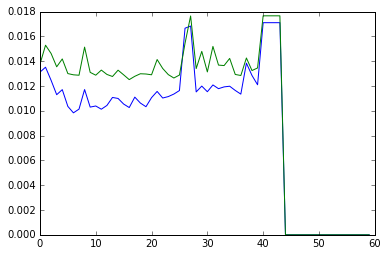

In [185]:
# 圧倒的過学習 adamすげ
plt.plot(training_error_array[:60])
plt.plot(test_error_array[:60])

In [186]:
a = feature_vec/norm_coef[:, np.newaxis]
gt2_vec = f_output(a.transpose(0, 2, 1))[0]
gt1_img = TN_utils.convert_gt2vec_to_gt1img(gt2_vec, img_shape=im_shape)

In [187]:
import scipy.io as sio
sio.savemat("../results/neuron_5_scale_gt1_train.mat", {"gt1_train": gt1_img})

In [188]:
# V outputのノルムを見てる
plt.figure(figsize=(15, 15))
plt.imshow(np.linalg.norm(gt1_img, axis=0).T)


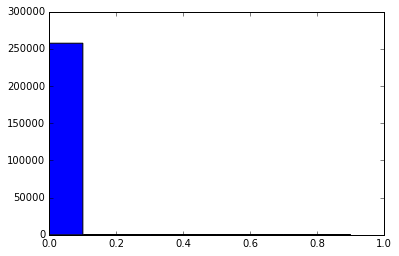

In [79]:
# V
gomi = plt.hist(np.linalg.norm(gt1_img, axis=0).flatten())

In [84]:
for i in range(len(param_od)):
    plt.figure()
    plt.title(param_list[i])
    plt.hist(param_list[i].get_value().flatten())

NameError: name 'param_od' is not defined

In [98]:
def power(x, rate, n):
    for i in range(n):
        x = x * rate
    return x

In [99]:
power(0.5, 1.01, 5)

0.52550502505

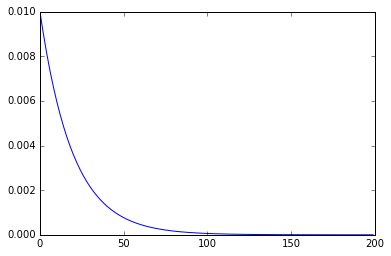

In [189]:
n_list = range(200)
plt.plot(n_list, [power(0.01, 0.95, n) for n in n_list])

In [67]:
np.sqrt(0)

0.0

In [44]:
dict.values()

TypeError: descriptor 'values' of 'dict' object needs an argument

In [214]:
x = np.linspace(-10, 10, 100)
plt.plot(x, (np.tanh(x-1)+1)/2)
plt.plot(x, np.max([np.tanh(x), np.zeros(x.shape)], axis=0))

plt.plot(x, 1./(1.+np.exp(-x)))